In [116]:
from typing import Dict, List
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
import plotly.express as px


warnings.simplefilter("ignore")

## Load data

In [2]:
def load_gz_csv_to_df(filepath: str) -> pd.DataFrame:
    try:
        return pd.read_csv(
            filepath, 
            compression='gzip', 
            header=0, sep=',', 
            error_bad_lines=False
        )
    except FileNotFoundError:
        exit(1)

bu_df = load_gz_csv_to_df('data/bu_feat.csv.gz')
train_df = load_gz_csv_to_df('data/train.csv.gz')
test_df = load_gz_csv_to_df('data/train.csv.gz')

In [3]:
bu_df.head(1)

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,1609,80100,50.096306,1.86722,69,4


In [4]:
train_df.head(1)

,day_id,but_num_business_unit,dpt_num_department,turnover
0,2017-09-30,64,127,580.308443


In [5]:
test_df.head(1)

,day_id,but_num_business_unit,dpt_num_department,turnover
0,2017-09-30,64,127,580.308443


My remarks: I find that the naming of the columns is not necessarily coherent. I found the following anomalies:
 * day_id : We are talking about a date and not a day, Moreover the term id is not necessarily appropriate here
 * The term department to talk about a commercial department of decathlon is confusing with geographical data
 * zod_idr_zone_dgr ? What is the meaning of this column ?

## UTILS

In [123]:
def agg_turnover_by_year_and_week_number_for_dpt(df: pd.DataFrame, dpt: int) -> pd.DataFrame:
    return (df[df["dpt_num_department"] == dpt]
     .groupby(["week_number", "year"], as_index=False)
     .agg({"turnover": ["sum"]})[["turnover", "week_number", "year"]]
     .sort_values(by=["year", "week_number"])
    )

def create_list_of_df_by_year(df: pd.DataFrame, years: List[int]) -> Dict[int, pd.DataFrame]:
    return {year: df[df["year"] == year ]for year in years}

def plot_turnover_by_year(dfs: Dict[int, pd.DataFrame], title: str, xlabel: str, ylabel: str):
    for (key, value) in dfs.items():
        plt.plot(value["week_number"],
            value["turnover"]["sum"],
            label=str(key),
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

## EDA

### Quick EDA training data

In [6]:
profile_train_df = ProfileReport(train_df, title="Pandas Profiling training df")

In [7]:
profile_train_df.to_widgets()


Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Conclusion:
* Turnover (CA) is correlated to the num of decathlon unit department 
* Turnover is skewed, we need to take this information into account for the training/inference
* Some Turnover values are null, I need more information to decide if they are anomalies 
* No missing data
* We have only 4 differents departments

### Quick EDA business unit data

In [8]:
profile_bu_df = ProfileReport(bu_df, title="Pandas Profiling bu df")

In [9]:
profile_bu_df.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Conclusion:
* What is the meaning of zod_idr_zone_dgr ?
* What is the meaning of but_region_idr_region ? 
* Postcode is correlated to the latitude and longitude, no surprise about that


## Preliminary questions & data exploration
### a. Which department made the highest turnover in 2016?

In [126]:
train_df["day_id"] = pd.to_datetime(train_df["day_id"], format="%Y-%m-%d")
train_df["week_number"] = train_df["day_id"].dt.week
train_df["year"] = train_df["day_id"].dt.year

In [30]:
(train_df[
        (train_df.day_id >= "2016-01-01")&(train_df.day_id <= "2016-12-31")
    ]
     .groupby(["dpt_num_department"])
     .agg({"turnover": ["sum"]})["turnover"]
     .sort_values(by="sum", ascending = False)
     .head(1)
)

,sum
dpt_num_department,
127,3.378005e+07


The department with the highest turnover in 2016 was department 127.

### What are the top 5 week numbers (1 to 53) for department 88 in 2015 in terms of turnover over all stores?

In [45]:
(train_df[(train_df["day_id"].dt.year == 2015)&(train_df["dpt_num_department"] == 88)]
     .groupby(["week_number"])
     .agg({"turnover": ["sum"]})["turnover"]
     .sort_values("sum", ascending = False)
     .head(5)
)

,sum
week_number,
27,141679.864768
37,139674.400588
36,137825.642436
38,137232.460861
28,125835.541415


The top 5 weeks for department 88 in 2015 are:
* 27 (29th june to 5th of July)
* 37 (7th of september to 13th of september)
* 36 (31st of august to 6th of september)
* 38 (14th of september to 20th of september)
* 28 (6th of july to 12th of july)

### c. What was the top performer store in 2014?

In [47]:
(train_df[(train_df["day_id"].dt.year == 2014)]
     .groupby(["but_num_business_unit"])
     .agg({"turnover": ["sum"]})["turnover"]
     .sort_values("sum", ascending = False)
     .head(5)
)

,sum
but_num_business_unit,
121,327806.356464
17,311496.294164
118,301938.962571
189,296147.653207
100,285379.195910


### d. Based on sales can you guess what kind of sport represents departement 73?

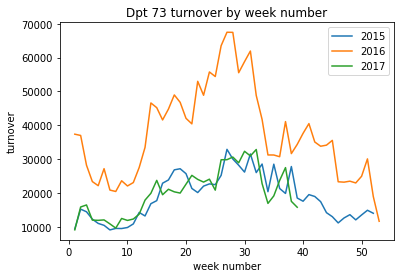

In [128]:
dpt_73_turnover_year_and_week_nb_df = agg_turnover_by_year_and_week_number_for_dpt(train_df, 73)
list_dpt_73_turnover_by_year_df =  create_list_of_df_by_year(
    dpt_73_turnover_year_and_week_nb_df, 
    [2015, 2016, 2017]
)
plot_turnover_by_year(
    list_dpt_73_turnover_by_year_df, 
    title="Dpt 73 turnover by week number", 
    xlabel="week number", 
    ylabel="turnover",
)

Based on the turnover of these 3 years, we can see a seasonality that could be verified from a statistical point of view. This seasonality indicates us a strong evolution of the sales during the summer, which lets me think that this department contains aquatic sports but not that we notice sales throughout the year.

### e. Based on sales can you guess what kind of sport represents departement 117?

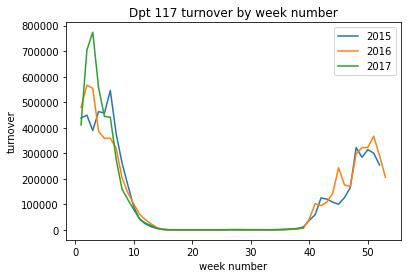

In [129]:
dpt_117_turnover_year_and_week_nb_df = agg_turnover_by_year_and_week_number_for_dpt(train_df, 117)
list_dpt_117_turnover_by_year_df =  create_list_of_df_by_year(
    dpt_117_turnover_year_and_week_nb_df, 
    [2015, 2016, 2017]
)
plot_turnover_by_year(
    list_dpt_117_turnover_by_year_df, 
    title="Dpt 117 turnover by week number", 
    xlabel="week number", 
    ylabel="turnover",
)

On the contrary, the turnover of department 117 shows us a seasonality only during winter and almost no sales during winter. We can therefore hypothesize that this department mainly includes winter sports (skiing, snowboarding, winter clothing, etc.)

### f. What other insights can you draw from the data? Provide plots and figures if
needed. (Optional)

TO DO, IF I HAVE EXTRA TIME